## Protein-Protein Binding Affinity Prediction using Random Forest Regressor

##### Beryl Ramadhian Aribowo 
##### DDP - Master, Kanazawa University

https://github.com/berylgithub

### Feature Extraction

The data is pre-processed to acquire the $D=\{(y^{(n)}, \vec{x}^{(n)})\}^N_{n=1}$ array. By calculating the Heaviside step function that counts the contacts of atoms between proteins ($d_{cutoff}$) within 12 Angstrom. The formula to count the number of occurence between $j$ and $i$ atom is as follows:
<br>
$x_{Z(P_X(j)),Z(P_Y(i))}\equiv\sum^{K_j}_{k=1}\sum^{L_i}_{l=1} \odot (d_{cutoff} - d_{kl})$
<br>

Here $P_X(j)$ corresponds to the protein atoms within the first chain of the protein pairing combination, and $P_Y(i)$ corresponds to the protein atoms within the second one, where four atom types are considered respectively as follows:
<br>
$\{P_N(j)\}_{j=1}^{4} = \{C,N,O,S\}$, $N \in Z^+$,<br>
The hydrophobic patches and acid patches interactions respectively are also considered: 
<br>
- hydrophobic patch : $\{C\alpha_H\}$
<br>
- acid patch : $\{C\alpha_A\}$,
<br>

where $C\alpha_H$ and $C\alpha_A$ is the total interactions between carbon-alpha on Hydrophobic and Acid patch respectively.

Therefore the total atomic interaction features used are $|\{P_N(j)\}_{j=1}^{4}|^2 + |\{C\alpha_H\}| + |\{C\alpha_A\}| = 18$

Suppose there are four chains of protein $S = \{P_1, P_2, P_3, P_4 \}$, the interaction is the combinations of two chains, hence the total of interactions between two chains for this case is $c^{|S|}_2$=6 (where $c$ here refers to combination formula), the list of chains combination are as follows:
<br>
$\sum interaction = interaction(P_1, P_2) + interaction(P_1,P_3) + interaction(P_1,P_4) + interaction(P_2,P_3) + interaction(P_2,P_4) + interaction(P_3,P_4)$

The script used for data preprocessing and feature extraction is available at https://github.com/berylgithub/ppbap.

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from math import sqrt

import pickle
import os

In [4]:
'''Dataset Loader'''
def dataset_loader(filepath):
    data = []
    try:
        with open(filepath, 'rb') as fr:
            try:
                while True:
                    data.append(pickle.load(fr))
            except EOFError:
                pass            
    except FileNotFoundError:
        print('File is not found')
    saved_ids = [d['id'] for d in data]
    return data

standard_dataset = os.getcwd()+'/Data/dataset_alpha_121019.pkl'
combined_ha_dataset = os.getcwd()+'/Data/dataset_ha_alpha_122319.pkl'
dataset = dataset_loader(combined_ha_dataset)

features = np.array([data['x_vector'] for data in dataset])
labels = np.array([data['y'] for data in dataset])
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=13)
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1812, 18)
Training Labels Shape: (1812,)
Testing Features Shape: (604, 18)
Testing Labels Shape: (604,)


In [5]:
'''Model Loader'''
standard_model = os.getcwd()+"/Model/rf_pp_alpha.pkl"
combined_ha_model= os.getcwd()+"/Model/rf_pp_ha_alpha.pkl"
with open(combined_ha_model, "rb") as f:
    rf = pickle.load(f)

In [6]:
'''Model evaluation on training set'''
#Mean Absolute Error
preds = rf.predict(x_train)
errors = abs(preds - y_train)
print('Mean Absolute Error:', round(np.mean(errors), 2))

#Mean Absolute Percentage Error & Accuracy
mape = 100 * (errors / y_train)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

#Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_train, preds))
print('Root Mean Squared Error :', round(rmse, 2))

#Pearson Correlation Coefficient (PCC) score
pcc = pearsonr(y_train, preds)
print('Pearson Correlation Coefficient :', round(pcc[0],2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean Absolute Error: 0.5
Accuracy: 92.21 %.
Root Mean Squared Error : 0.65
Pearson Correlation Coefficient : 0.98


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


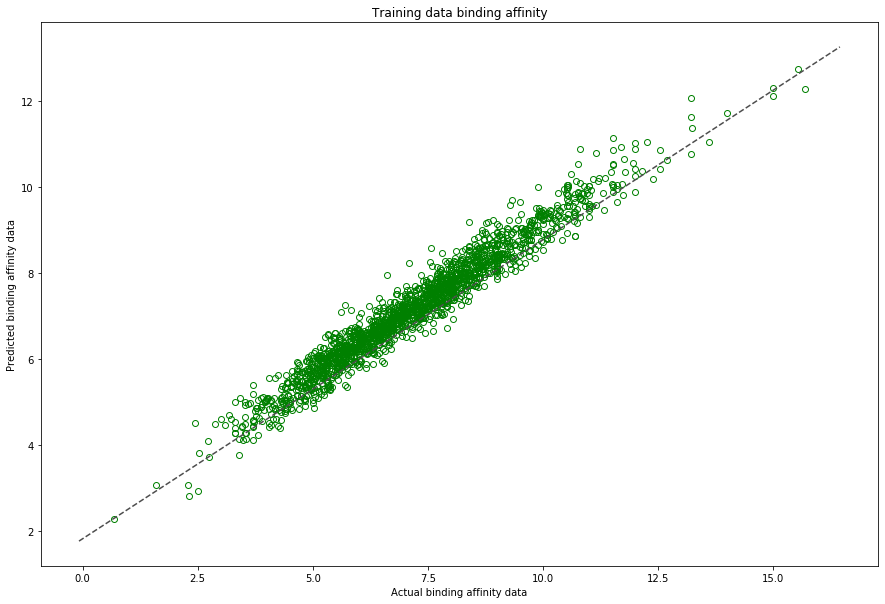

In [8]:
'''Visualization on training set'''
import matplotlib.pyplot as plt

fig_size = np.zeros(2)
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

f, ax = plt.subplots()

plt.plot(y_train, preds, 'o', markerfacecolor="None", markeredgecolor='green', markeredgewidth=1)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.title("Training data binding affinity")
plt.xlabel('Actual binding affinity data')
plt.ylabel('Predicted binding affinity data')
#plt.legend()
plt.show()

In [9]:
'''Model evaluation on Test set'''
#Mean Absolute Error
preds = rf.predict(x_test)
errors = abs(preds - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))

#Mean Absolute Percentage Error & Accuracy
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

#Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, preds))
print('Root Mean Squared Error :', round(rmse, 2))

#Pearson Correlation Coefficient (PCC) score
pcc = pearsonr(y_test, preds)
print('Pearson Correlation Coefficient :', round(pcc[0],2))

Mean Absolute Error: 1.41
Accuracy: 77.68 %.
Root Mean Squared Error : 1.8
Pearson Correlation Coefficient : 0.43


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


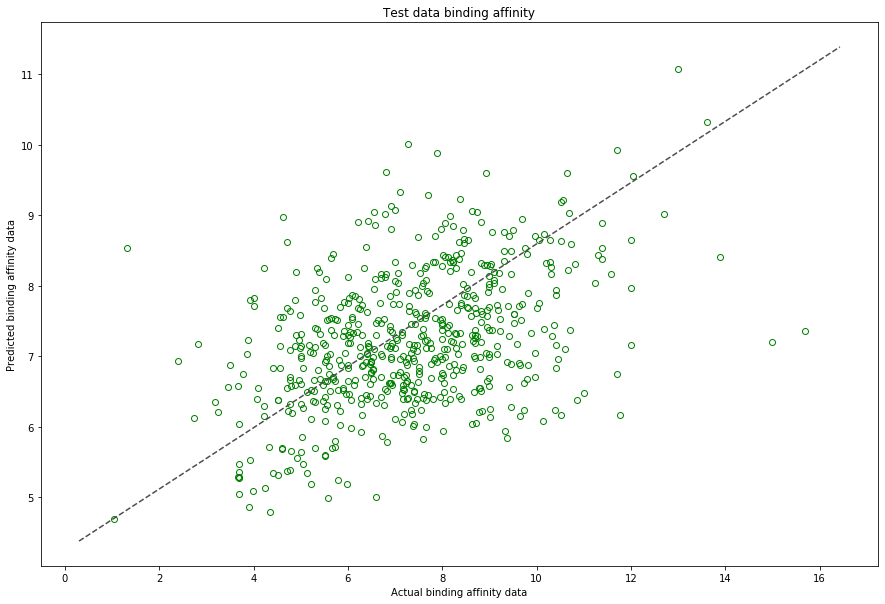

In [10]:
'''Visualization on test set'''
import matplotlib.pyplot as plt

fig_size = np.zeros(2)
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

f, ax = plt.subplots()

plt.plot(y_test, preds, 'o', markerfacecolor="None", markeredgecolor='green', markeredgewidth=1)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.title("Test data binding affinity")
plt.xlabel('Actual binding affinity data')
plt.ylabel('Predicted binding affinity data')
#plt.legend()
plt.show()


Top Feature ranking:
1. feature 17 (0.109651)
2. feature 16 (0.101809)
3. feature 10 (0.074626)
4. feature 9 (0.060280)
5. feature 8 (0.060119)
6. feature 0 (0.056725)
7. feature 13 (0.054315)
8. feature 4 (0.050903)
9. feature 2 (0.050573)
10. feature 6 (0.049587)
11. feature 12 (0.047491)
12. feature 1 (0.043287)
13. feature 7 (0.043235)
14. feature 5 (0.042671)
15. feature 14 (0.042258)
16. feature 3 (0.040270)
17. feature 11 (0.039157)
18. feature 15 (0.033044)


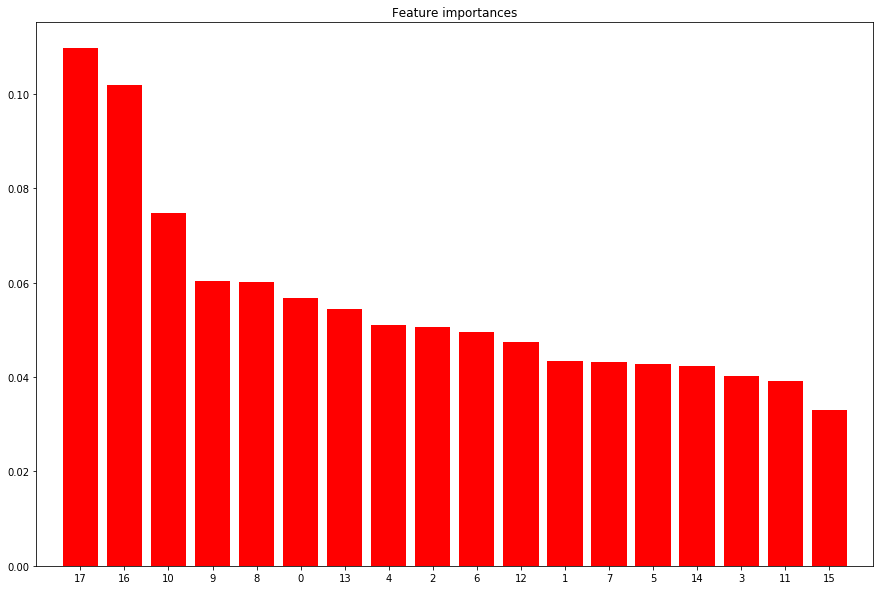

In [13]:
'''
Top 20 features based on combination of:
atom_types = ['C','N','O','F','P','S','Cl','Br','I']
'''

importance = rf.feature_importances_

#indices = np.argsort(importance)[::-1][:20]
indices = np.argsort(importance)[::-1]

print("Top Feature ranking:")
n = importance.shape[0]
#n = 20
for f in range(n):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))


plt.figure()
plt.title("Feature importances")
plt.bar(range(n), importance[indices],
       color="r", align="center")
plt.xticks(range(n), indices)
plt.xlim([-1, n])
plt.show()

In [14]:
'''K-Fold model evaluation'''
folds = [3,4,5,7,10]
kfolds=[]
for fold in folds:
    #with open(os.getcwd()+"/Model/rf_pp_a_"+str(fold)+"fold_best.pkl", "rb") as f:
    with open(os.getcwd()+"/Model/rf_pp_ha_a_"+str(fold)+"fold_best.pkl", "rb") as f:
        kfolds.append(pickle.load(f))

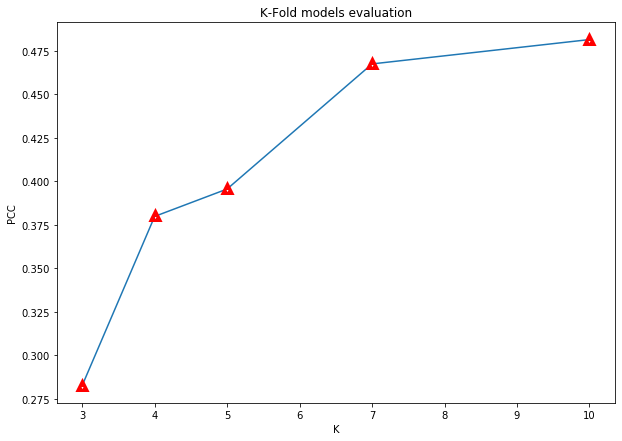

In [15]:
ks = np.array([kfold["k"] for kfold in kfolds])
pcc_tests = np.array([kfold["pcc_test"] for kfold in kfolds])
pcc_trains = np.array([kfold["pcc_train"] for kfold in kfolds])

fig_size = np.zeros(2)
fig_size[0] = 10
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.plot(ks, pcc_tests, '^-', markerfacecolor="None", markeredgecolor='red', markeredgewidth=5)
plt.title("K-Fold models evaluation")
plt.xlabel('K')
plt.ylabel('PCC')
#plt.legend()
plt.show()

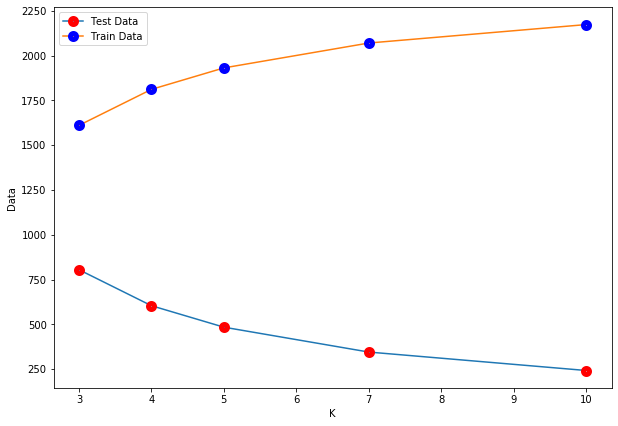

In [16]:
total_train_data = np.array([kfold["train_idx"].shape[0] for kfold in kfolds])
total_test_data = np.array([kfold["test_idx"].shape[0] for kfold in kfolds])
plt.plot(ks, total_test_data,'o-', markerfacecolor="None", markeredgecolor='red', markeredgewidth=5, label="Test Data")
plt.plot(ks, total_train_data,'o-', markerfacecolor="None", markeredgecolor='blue', markeredgewidth=5, label="Train Data")
plt.xlabel("K")
plt.ylabel("Data")
plt.legend()
plt.show()

In [5]:
'''Full-data model load'''
def data_load(filename):
    '''
    data checker
    '''
    data = []
    try:
        with open(filename, 'rb') as fr:
            try:
                while True:
                    data.append(pickle.load(fr))
            except EOFError:
                pass            
    except FileNotFoundError:
        print('File is not found')
    return data

full_model = os.getcwd()+"/Model/rf_pp_ha_alpha_full.pkl"
with open(full_model, "rb") as f:
    rf = pickle.load(f)

### Inference on PC-PC

In [69]:
path = os.getcwd()+"/Data/data_PC-PC.pkl"
data =data_load(path)
ids = [d["id"] for d in data]
vectors = [d["x_vector"] for d in data]
temp = ids[1]
del ids[1]
ids.append(temp)
temp = vectors[1]
del vectors[1]
vectors.append(temp)
pred_PCPC = rf.predict(vectors)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


### Inference on PC-CytF

In [70]:
path = os.getcwd()+"/Data/data_PC-CF.pkl"
data =data_load(path)
ids = [d["id"] for d in data]
vectors = [d["x_vector"] for d in data]
temp = ids[1]
del ids[1]
ids.append(temp)
temp = vectors[1]
del vectors[1]
vectors.append(temp)
pred_PCCF = rf.predict(vectors)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


### Inference on 4azu

In [71]:
path = os.getcwd()+"/Data/data_4azu.pkl"
data =data_load(path)
vectors = [d["x_vector"] for d in data]
pred_4azu = rf.predict(vectors)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


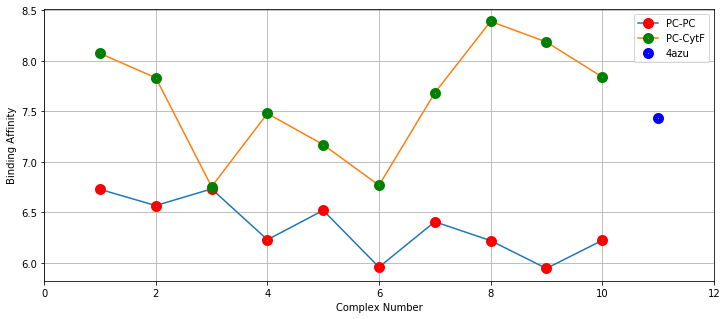

In [72]:
import matplotlib.pyplot as plt
length = len(ids)
idx = np.linspace(1, length, length)
fig_size = np.zeros(2)
fig_size[0] = 12
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.xlim([0,12])
plt.plot(idx, pred_PCPC,'o-', markerfacecolor="None", markeredgecolor='red', markeredgewidth=5, label="PC-PC" )
plt.plot(idx, pred_PCCF,'o-', markerfacecolor="None", markeredgecolor='green', markeredgewidth=5, label="PC-CytF")
plt.plot(11, pred_4azu,'o', markerfacecolor="None", markeredgecolor='blue', markeredgewidth=5, label="4azu")
plt.xlabel("Complex Number")
plt.ylabel("Binding Affinity")
plt.legend()
plt.grid(True)
plt.show()